In [96]:
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt

HOME = "/scicore/home/schwede/pudziu0000/"

def get_distances(data_file, emb_file):
    data = pd.read_csv(data_file, sep="\t")
    embs = torch.load(emb_file)
    embs = torch.squeeze(embs)
    embs = embs.to(torch.float64)
    
    # Separate embeddings: first 1280 dims are for R, the remaining for L
    r_embs = embs[:, :1280]
    l_embs = embs[:, 1280:]
    
    # Compute distances between embeddings of the pair
    dist_m = torch.cdist(r_embs, l_embs)
    distances = dist_m.diag()
    
    # Save distances into two collections: one for positive pairs, other for negative ones
    pos_mask = list(map(bool, data['label'].tolist()))
    neg_mask = list(map(bool, (1-data['label']).tolist()))
    
    pos_dists = distances[pos_mask]
    neg_dists = distances[neg_mask]

    return pos_dists, neg_dists

def plot_distributions(dist1, dist2, title):
    matplotlib.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(10, 5))
    
    plt.hist(dist1, color='red', alpha=0.5, label='positive')
    plt.hist(dist2, color='blue', alpha=0.5, label='negative')
    plt.xlabel('distance')
    plt.ylabel('frequency')
    plt.title(title)
    plt.legend()
    
    plt.show()

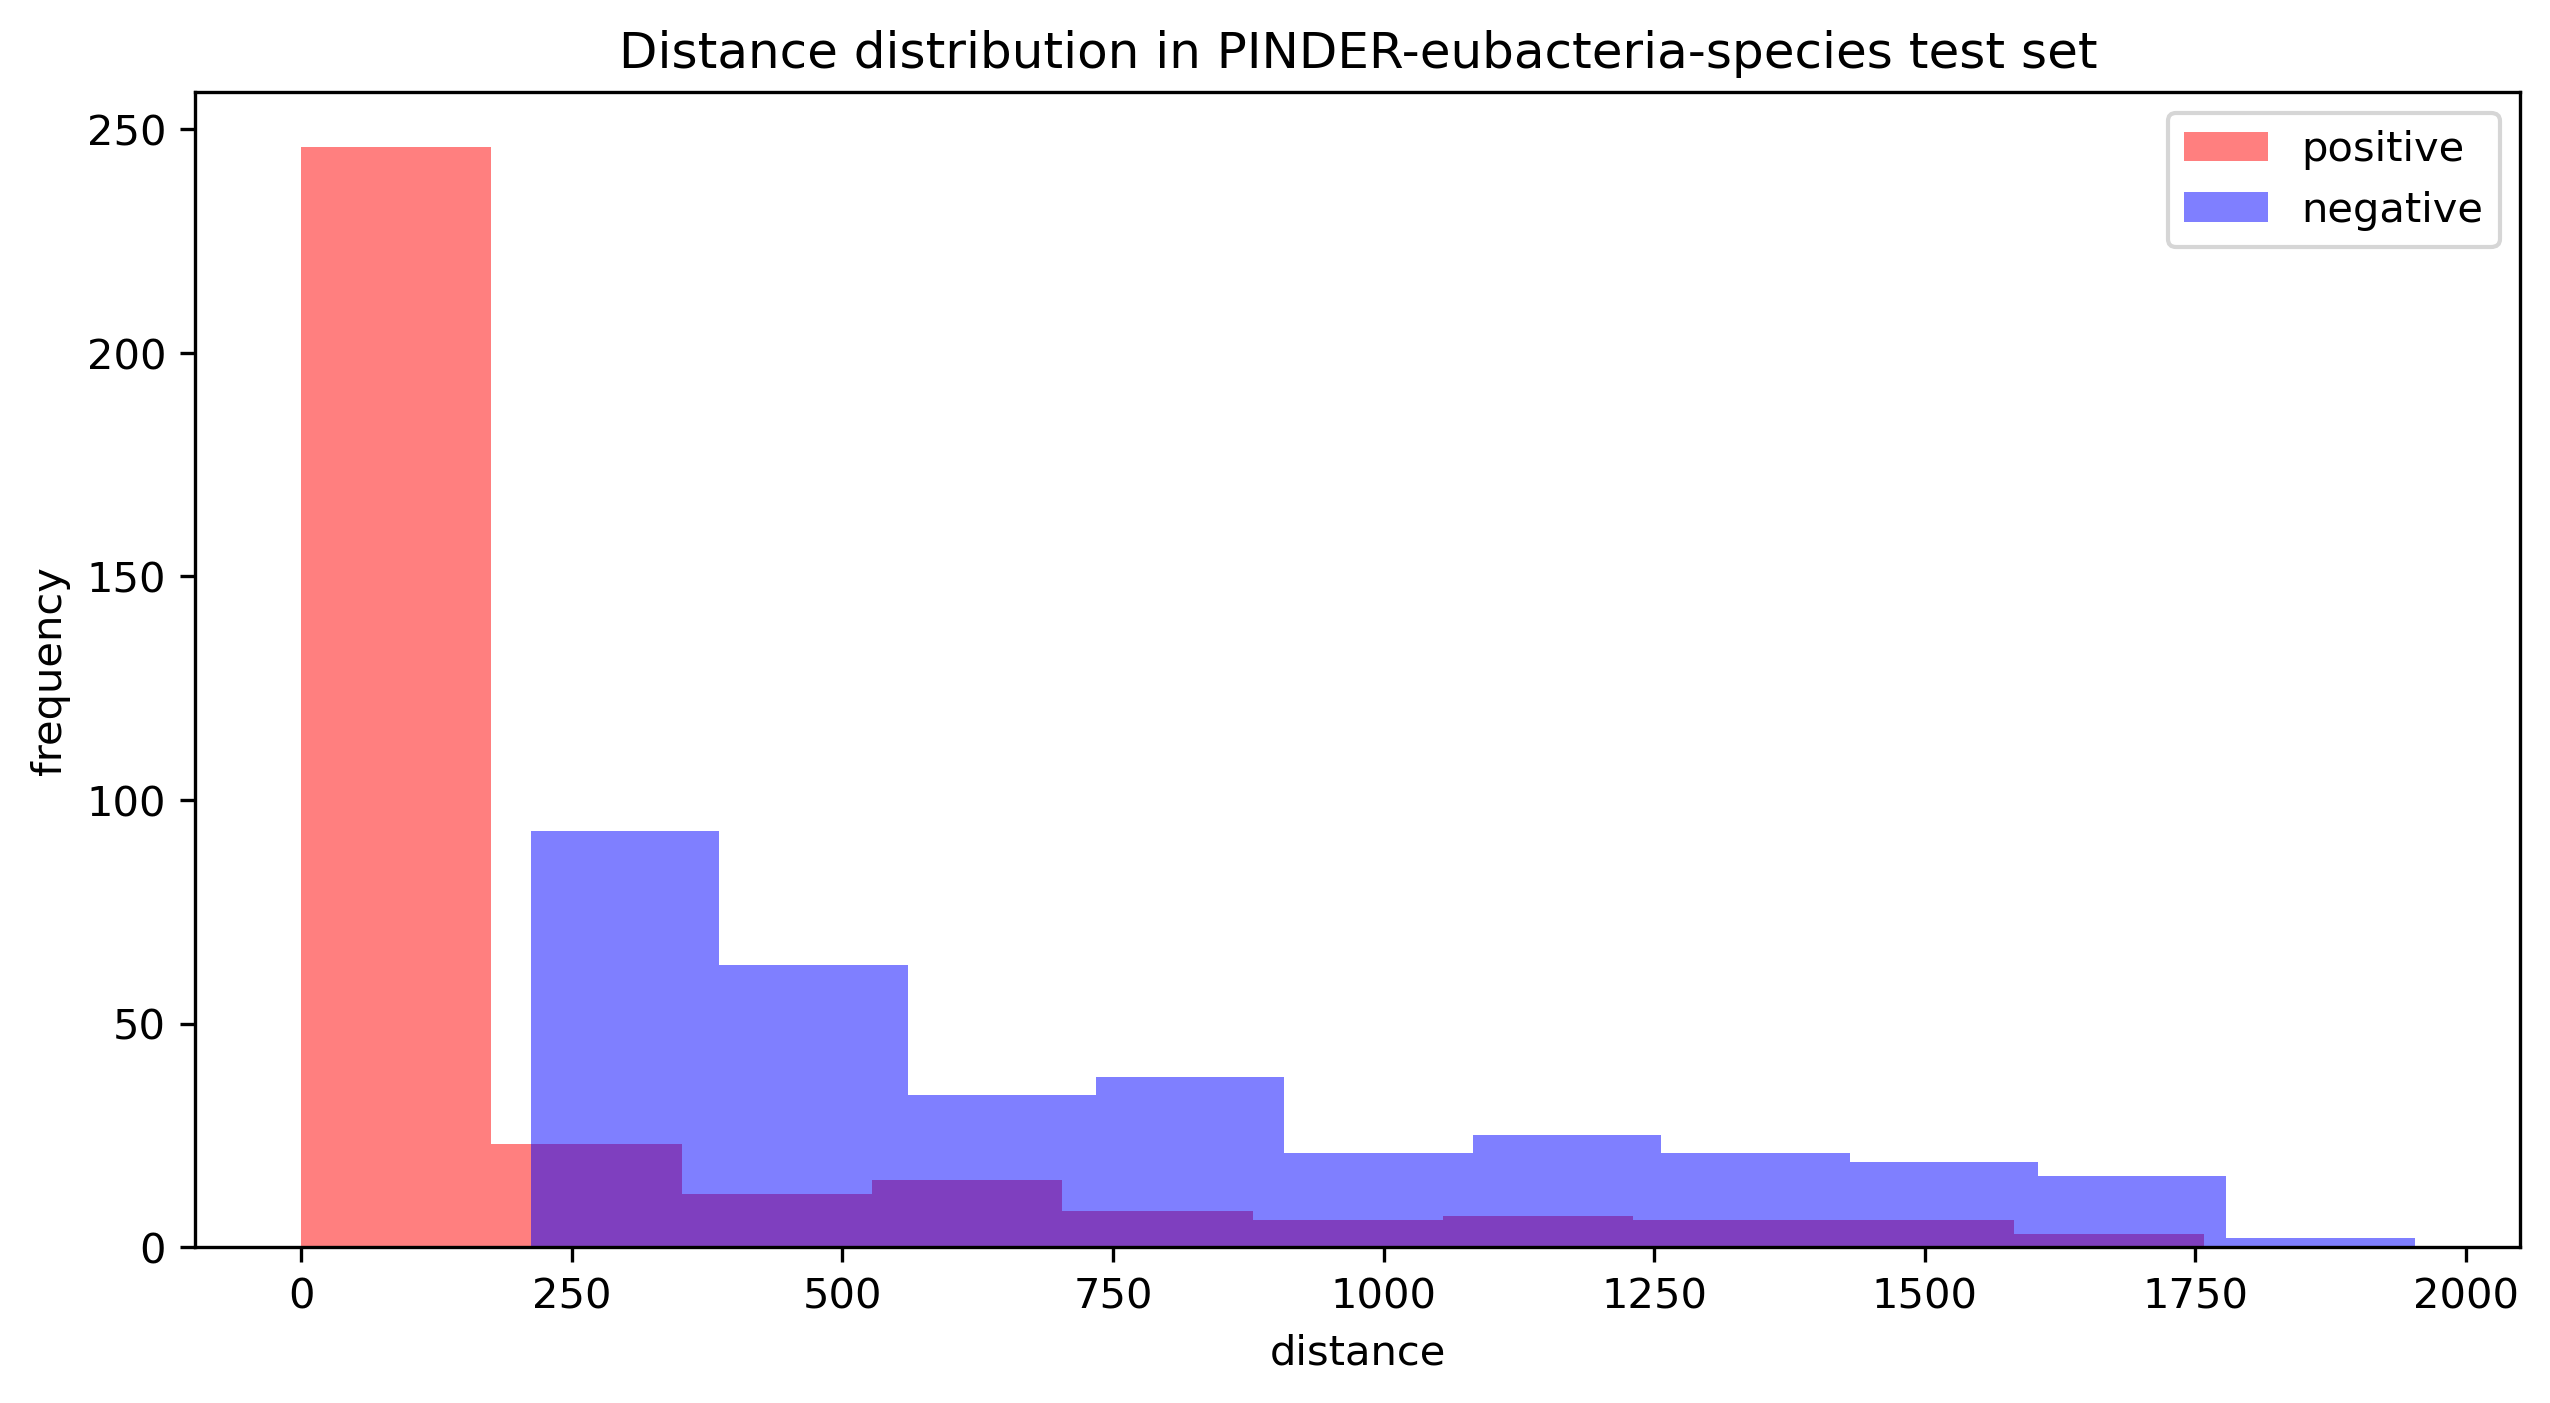

In [97]:
pinder_data_file = f"{HOME}/projects/gLM/data/PINDER/eubacteria_5_1024_512_species/test.txt"
pinder_emb_file = f"{HOME}/projects/gLM/embeddings/PINDER-eubacteria-species/gLM2_650M_sep/test.pt"

pinder_pos_dists, pinder_neg_dists = get_distances(pinder_data_file, pinder_emb_file)
plot_distributions(pinder_pos_dists, pinder_neg_dists, title="Distance distribution in PINDER-eubacteria-species test set")

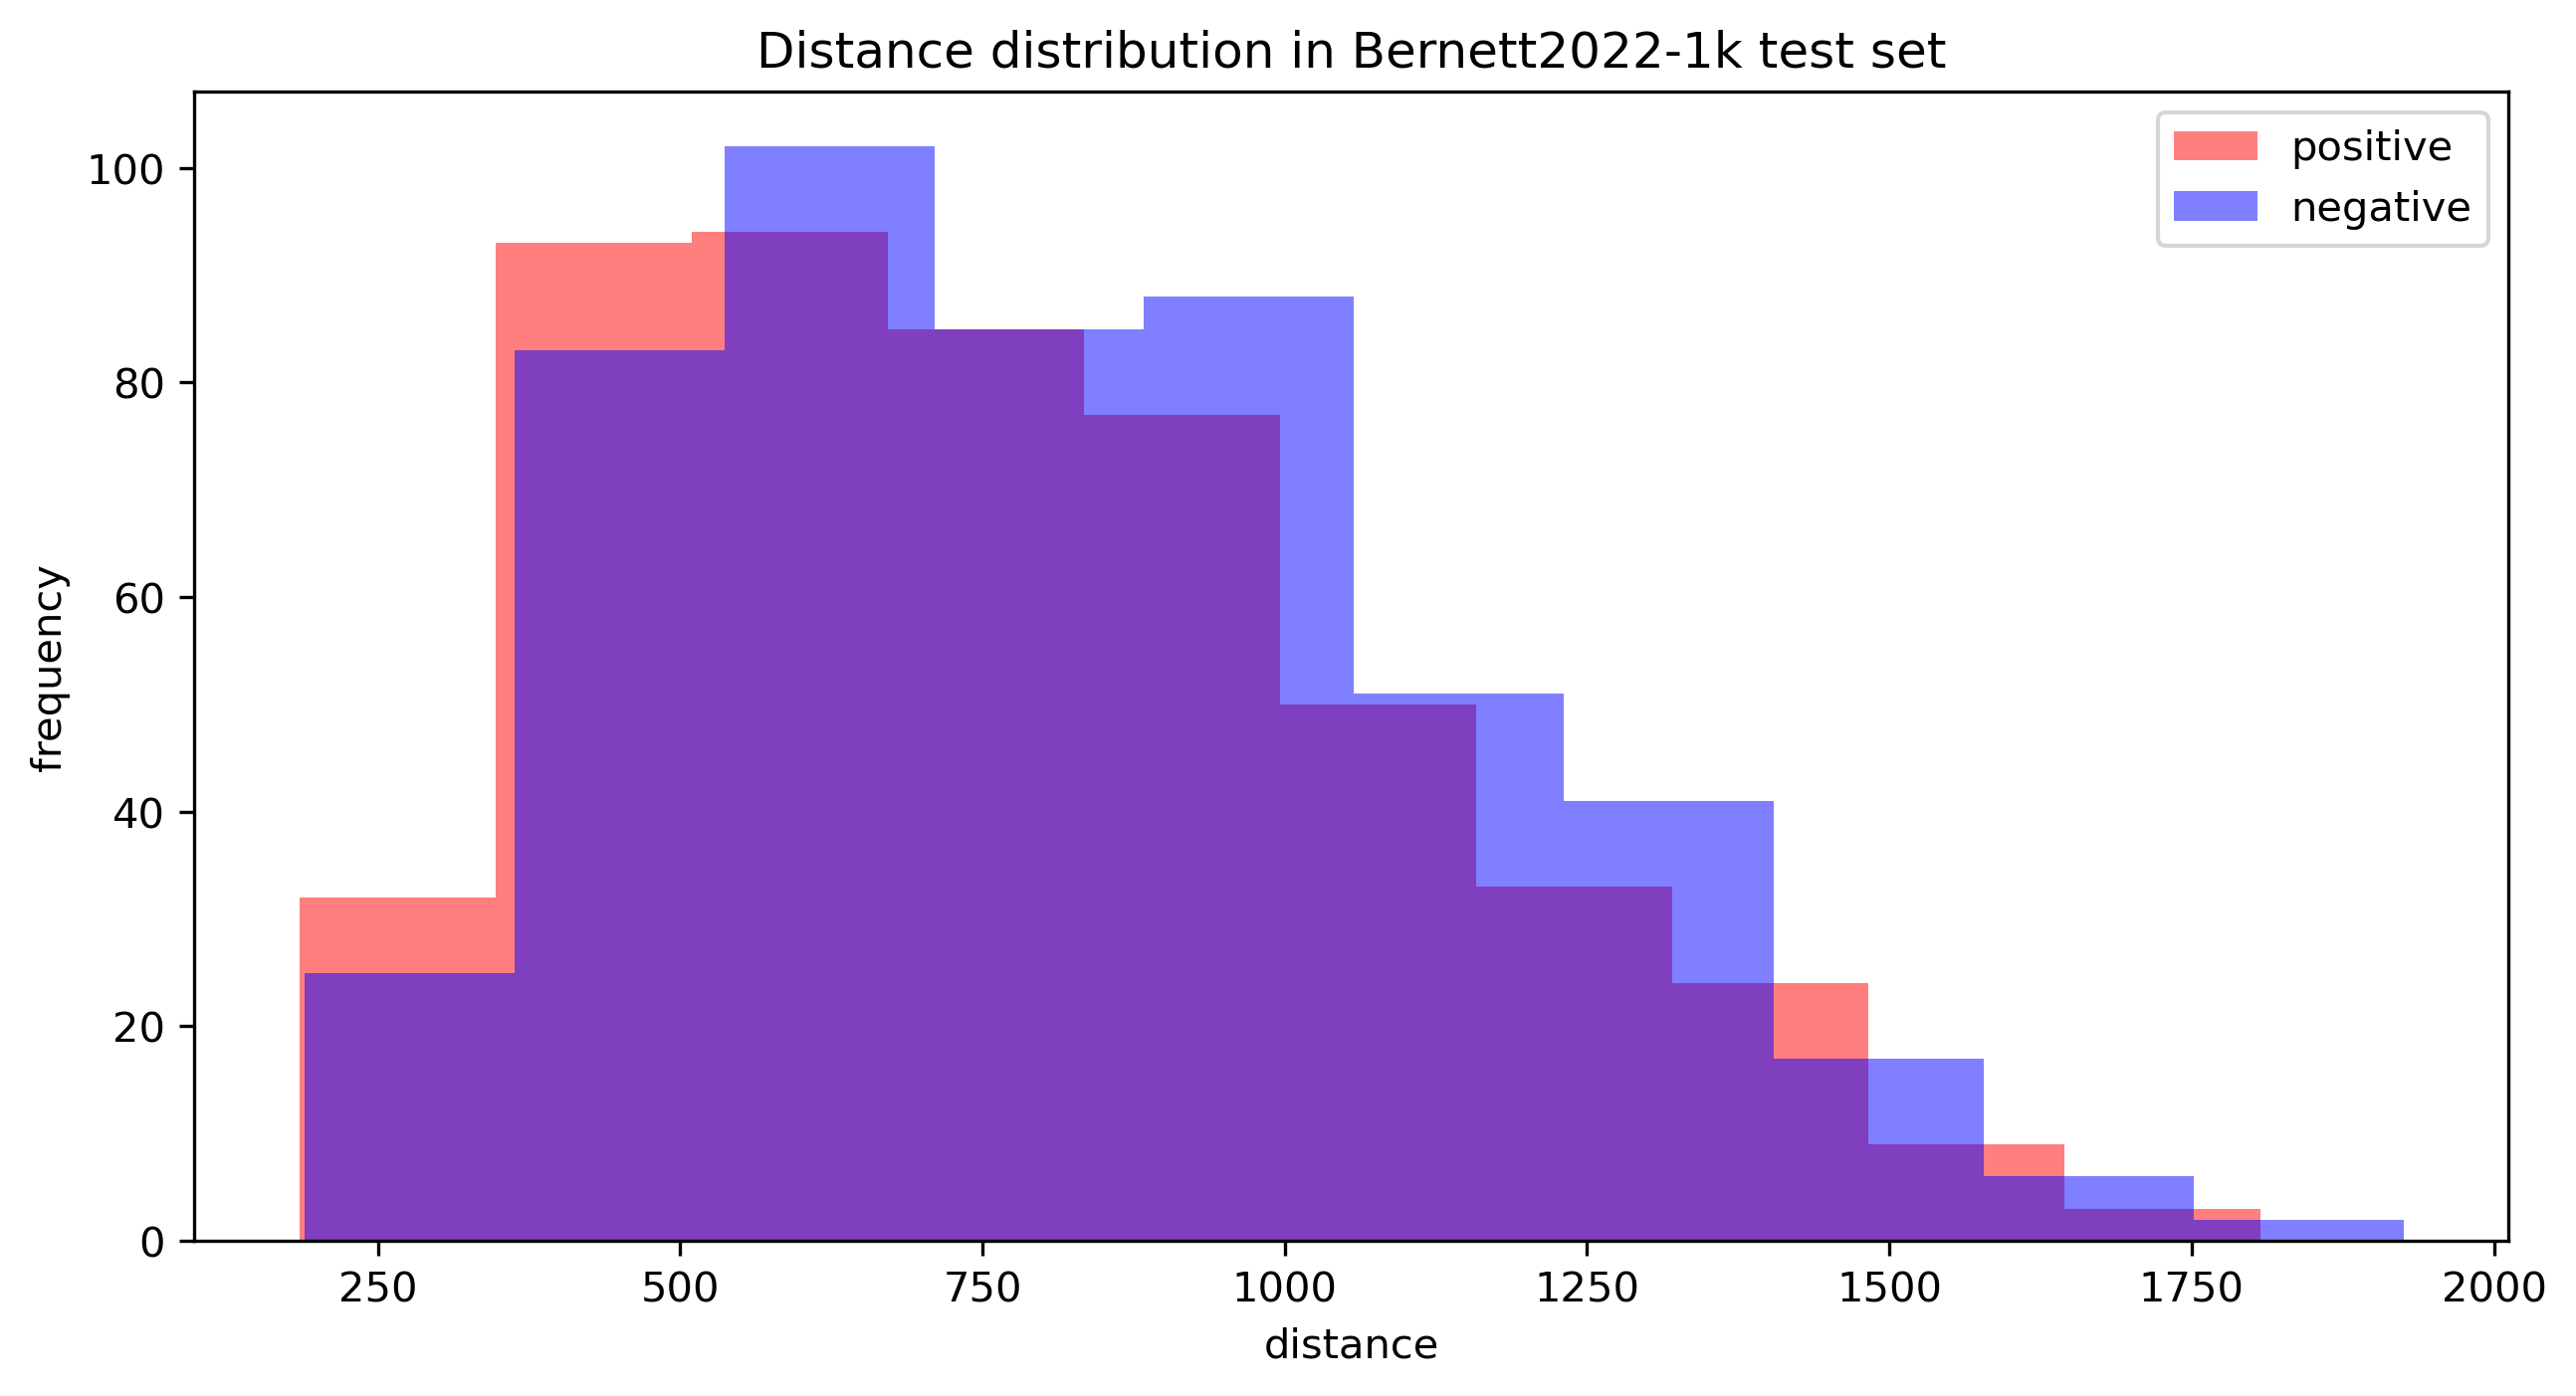

In [98]:
bernett_data_file = f"{HOME}/projects/gLM/data/Bernett2022_1k/test.txt"
bernett_emb_file = f"{HOME}/projects/gLM/embeddings/Bernett2022_1k/gLM2_650M_sep/test.pt"

bernett_pos_dists, bernett_neg_dists = get_distances(bernett_data_file, bernett_emb_file)
plot_distributions(bernett_pos_dists, bernett_neg_dists, title="Distance distribution in Bernett2022-1k test set")